# Exercise Week 6

- Dave Schurtenberger
- Luca Kyburz
- Pascal Gansner
- Sofia Horlacher

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL

from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils import time_plot, get_figure, fit_and_forecast, plot_fit_and_forecast
from data import get_apple_5y, get_switzerland_temperature, get_france_death_rate_20y, get_random_walk

# Simulate & Analyse Synthetic Signals

### Generate Synthetic Signals

- **Signal 1**: Trend only
- **Signal 2**: Seasonal only
- **Signal 3**: Trend + Seasonality
- **Signal 4**: Stationary noise

In [80]:
np.random.seed(42)
n_points = 200
train_size = int(n_points * 0.8)

date_index = pd.date_range(start='2020-01-01', periods=n_points, freq='D')

# Signal 1: Trend
drift_level = 0.5
signal1 = get_random_walk(seed=42, npoints=n_points, variance=4, drift=drift_level)
signal1 = pd.Series(signal1, index=date_index)

# Signal 2: Seasonality
period = 12
amplitude = 10
seasonal_component = amplitude * np.sin(2 * np.pi * np.arange(n_points) / period)
signal2 = seasonal_component + np.random.normal(0, 2, n_points)
signal2 = pd.Series(signal2, index=date_index)

# Signal 3: Trend + Seasonality
signal3 = get_random_walk(seed=43, npoints=n_points, variance=4, drift=0.3, seasonal=seasonal_component)
signal3 = pd.Series(signal3, index=date_index)

# Signal 4: Stationary noise
signal4 = pd.Series(np.random.normal(10, 3, n_points), 
                    index=date_index)

The next cell visualizes the signals

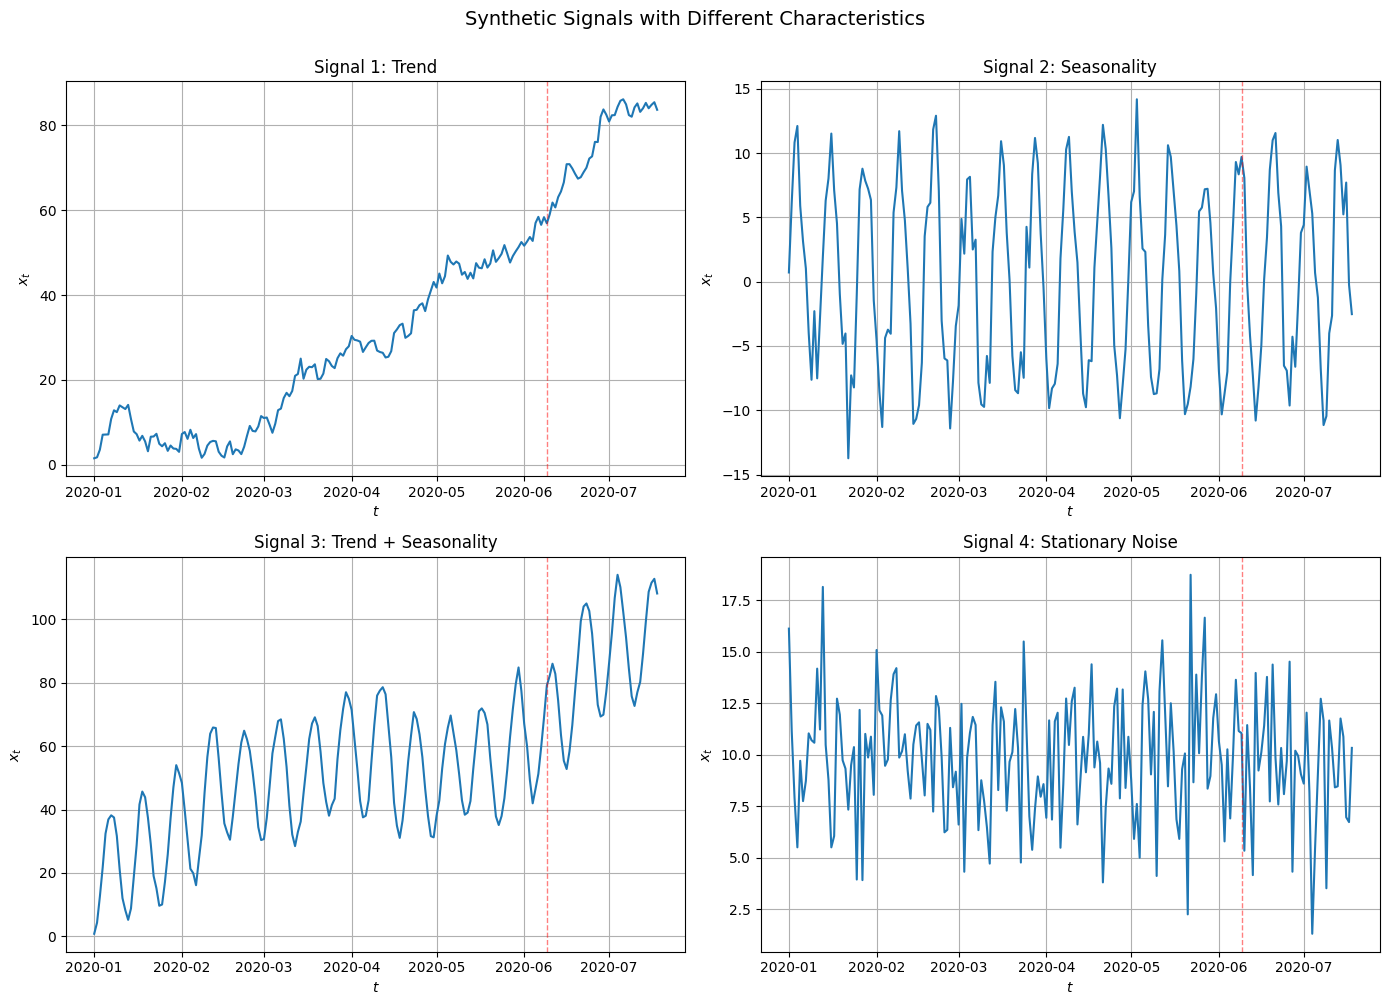

In [81]:
fig, axs = get_figure(nrows=2, ncols=2, figsize=(14, 10))
signals = {
    "Signal 1: Trend": signal1,
    "Signal 2: Seasonality": signal2,
    "Signal 3: Trend + Seasonality": signal3,
    "Signal 4: Stationary Noise": signal4
}

for ax, (title, signal) in zip(axs, signals.items()):
    time_plot(x=signal.index, y=signal, title=title, ax=ax)
    ax.axvline(x=signal.index[train_size], color='red', linestyle='--', linewidth=1, alpha=0.5)
    
fig.suptitle("Synthetic Signals with Different Characteristics", fontsize=14, y=1.00)
fig.tight_layout()

### Fit Different ETS Models

In [82]:
def compare_ets_models(signal, signal_name, train_size, ets_configs: dict):
    """Compare different ETS configurations on a signal"""
       
    results = []    
    for name, model in ets_configs.items():
        try:
            fitted_values, predictions, pred_interval = fit_and_forecast(model, signal, train_size)
            
            test_data = signal.iloc[train_size:]
            mse = mean_squared_error(test_data, predictions)
            mae = mean_absolute_error(test_data, predictions)
            
            # Get fitted parameters
            if hasattr(model, '_fitted_forecaster'):
                alpha = getattr(model._fitted_forecaster, 'smoothing_level', None)
                beta = getattr(model._fitted_forecaster, 'smoothing_trend', None)
                gamma = getattr(model._fitted_forecaster, 'smoothing_seasonal', None)
                phi = getattr(model._fitted_forecaster, 'damping_trend', None)
            else:
                alpha = beta = gamma = phi = None
            
            results.append({
                'Signal': signal_name,
                'Model': name,
                'MSE': mse,
                'MAE': mae,
                'α': alpha,
                'β*': beta,
                'γ': gamma,
                'φ': phi,
                'fitted': fitted_values,
                'predictions': predictions,
                'interval': pred_interval
            })
        except Exception as e:
            print(f"Error fitting {name}: {e}")
            continue
    
    return results

In [83]:

ets_configs = {
    'ETS(A,N,N)': AutoETS(error='add', trend=None, seasonal=None, auto=False),
    'ETS(A,A,N)': AutoETS(error='add', trend='add', seasonal=None, auto=False),
    'ETS(A,Ad,N)': AutoETS(error='add', trend='add', damped_trend=True, seasonal=None, auto=False),
    'ETS(A,N,A)': AutoETS(error='add', trend=None, seasonal='add', sp=period, auto=False),
    'ETS(A,A,A)': AutoETS(error='add', trend='add', seasonal='add', sp=period, auto=False),
}

In [84]:
print("Comparing ETS Models on Different Synthetic Signals")
print("=" * 80)

all_results = {}
for i, (name, signal) in enumerate(signals.items()):
    results = compare_ets_models(signal, name, train_size, ets_configs=ets_configs)
    all_results[name] = results
    
    df_results = pd.DataFrame([{k: v for k, v in r.items() if k not in ['fitted', 'predictions', 'interval']} 
                                for r in results])
    print(f"\n{name}")
    print("-" * 80)
    print(df_results.to_string(index=False))

Comparing ETS Models on Different Synthetic Signals

Signal 1: Trend
--------------------------------------------------------------------------------
         Signal       Model        MSE       MAE        α       β*        γ        φ
Signal 1: Trend  ETS(A,N,N) 397.769319 17.894267 0.946584      NaN      NaN      NaN
Signal 1: Trend  ETS(A,A,N) 139.868948 10.628301 0.898590 0.000090      NaN      NaN
Signal 1: Trend ETS(A,Ad,N) 372.772286 17.259450 0.882157 0.032925      NaN 0.846354
Signal 1: Trend  ETS(A,N,A) 368.117919 17.054267 0.999900      NaN 0.000024      NaN
Signal 1: Trend  ETS(A,A,A) 119.242802  9.710306 0.887857 0.000089 0.000011      NaN

Signal 2: Seasonality
--------------------------------------------------------------------------------
               Signal       Model        MSE      MAE      α           β*      γ        φ
Signal 2: Seasonality  ETS(A,N,N) 108.136041 8.302612 0.9999          NaN    NaN      NaN
Signal 2: Seasonality  ETS(A,A,N) 124.044866 9.041105 0.

In [85]:
def plot_forecasts(signal, signal_name, results):
    fig, axs = get_figure(nrows=2, ncols=3, figsize=(16, 10), sharey=True)

    for i, result in enumerate(results):
        if i < len(axs):
            ax = axs[i]
            time_plot(x=signal.index, y=signal, label='Actual', ax=ax, alpha=0.7)
            ax.axvline(x=signal.index[train_size], color='red', linestyle='--', linewidth=1, alpha=0.5)
            plot_fit_and_forecast(ax, result['fitted'], result['predictions'], 
                                result['interval'], model_name=result['Model'])
            ax.set_title(f"{result['Model']} | MSE={result['MSE']:.2f}")
            ax.legend(fontsize=8)

    if len(results) < len(axs):
        axs[-1].axis('off')

    fig.suptitle(f"{signal_name}: ETS Model Comparison", fontsize=14)
    fig.tight_layout()

The next cell shows the predictions of all the ets models for the first signal.

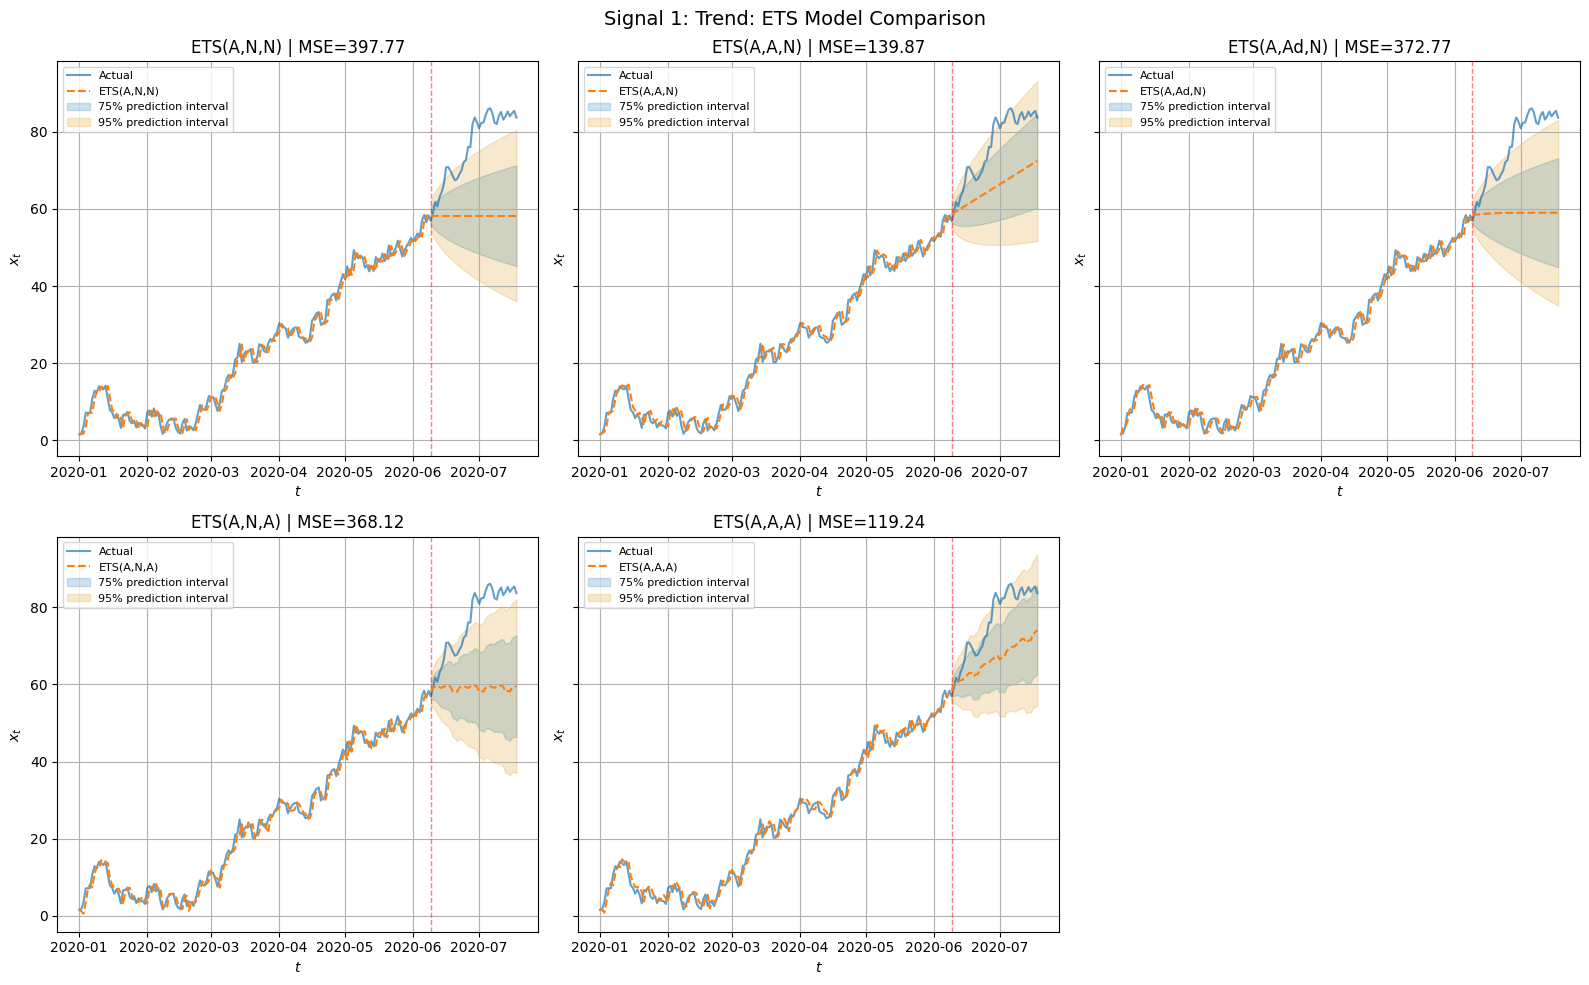

In [86]:
signal = list(signals.items())[0]
plot_forecasts(signal=signal[1],signal_name=signal[0], results=all_results[signal[0]])

The predictions on signal 2:

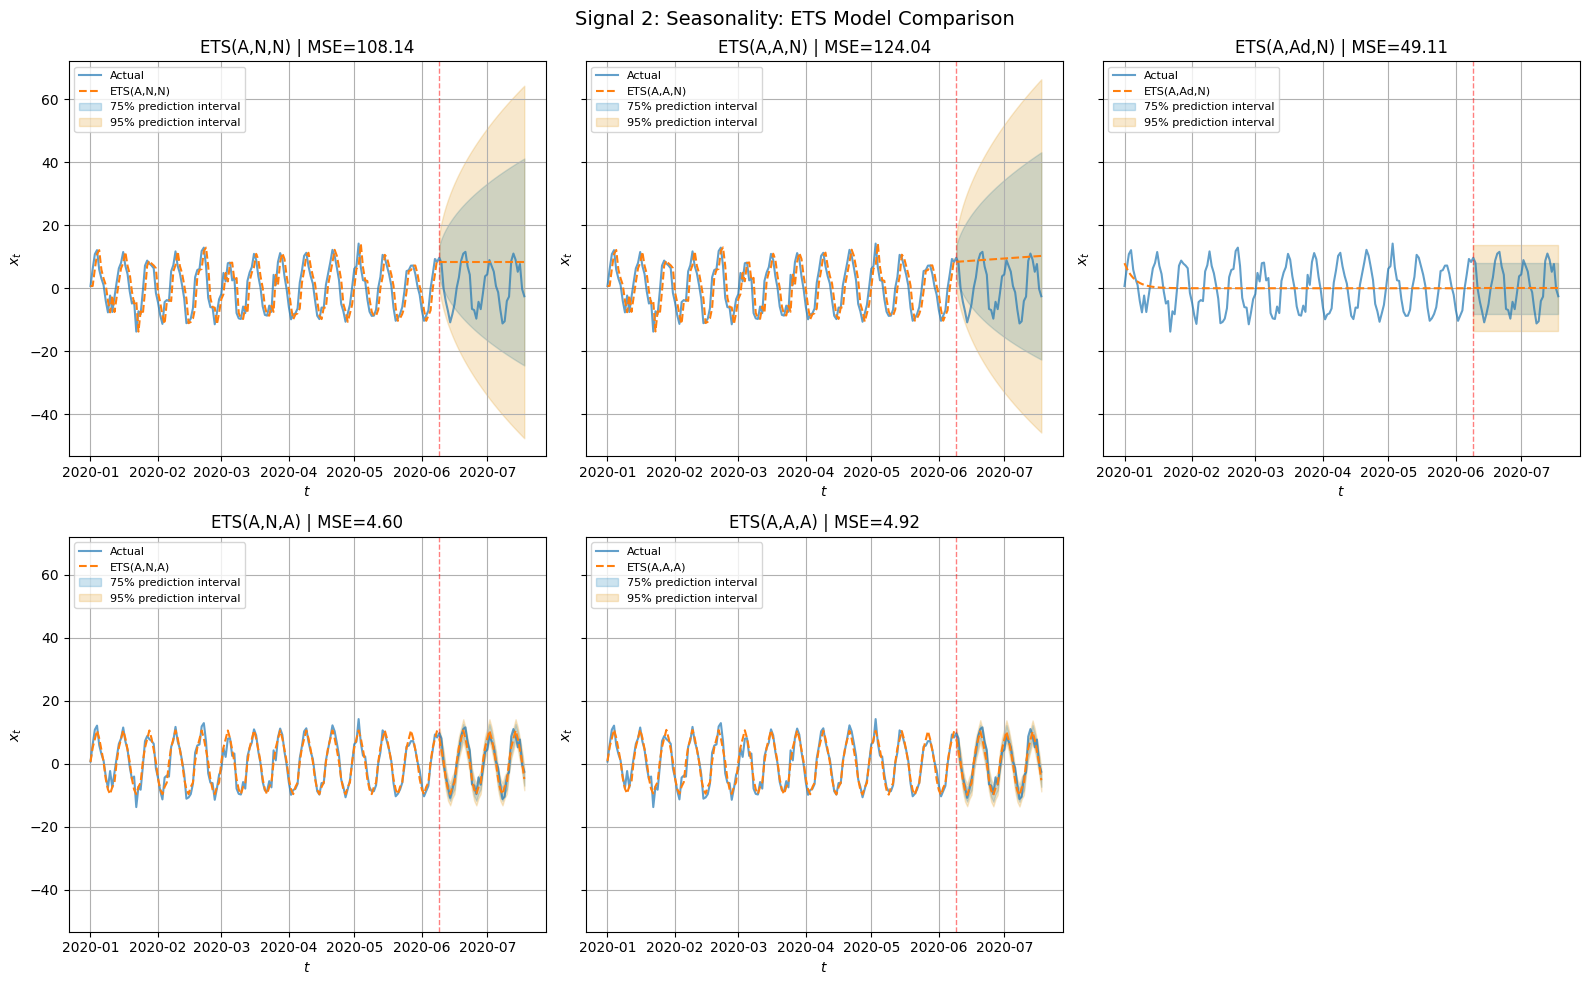

In [87]:
signal = list(signals.items())[1]
plot_forecasts(signal=signal[1],signal_name=signal[0], results=all_results[signal[0]])

The predictions on signal 3:

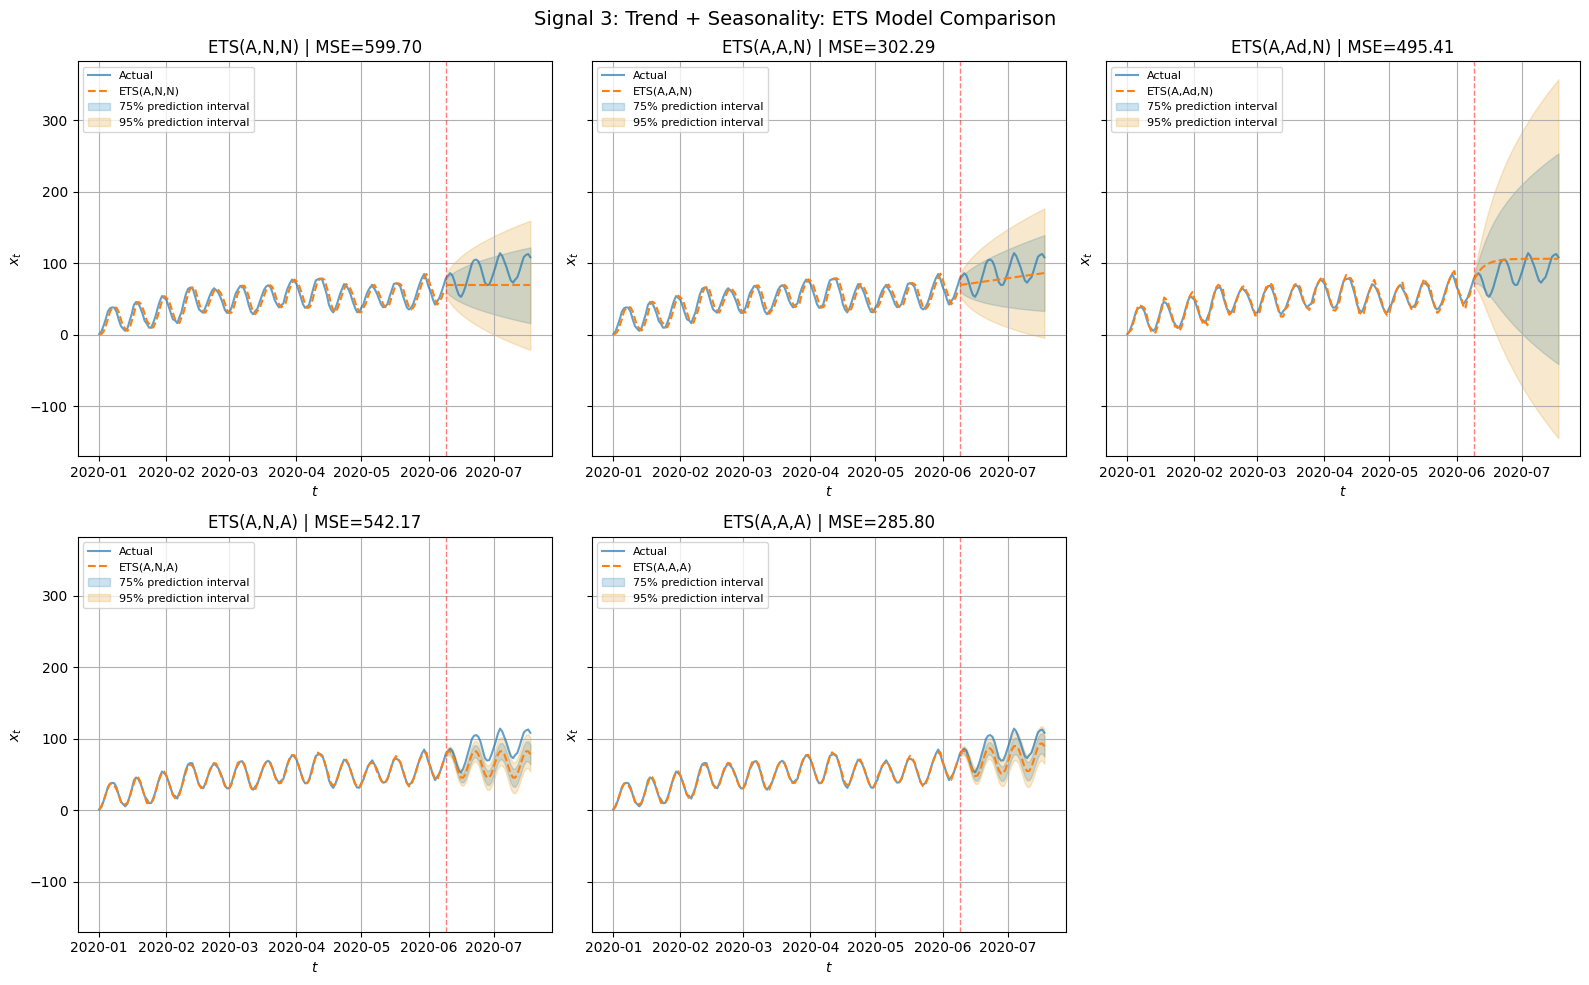

In [88]:
signal = list(signals.items())[2]
plot_forecasts(signal=signal[1],signal_name=signal[0], results=all_results[signal[0]])

The predictions on signal 4:

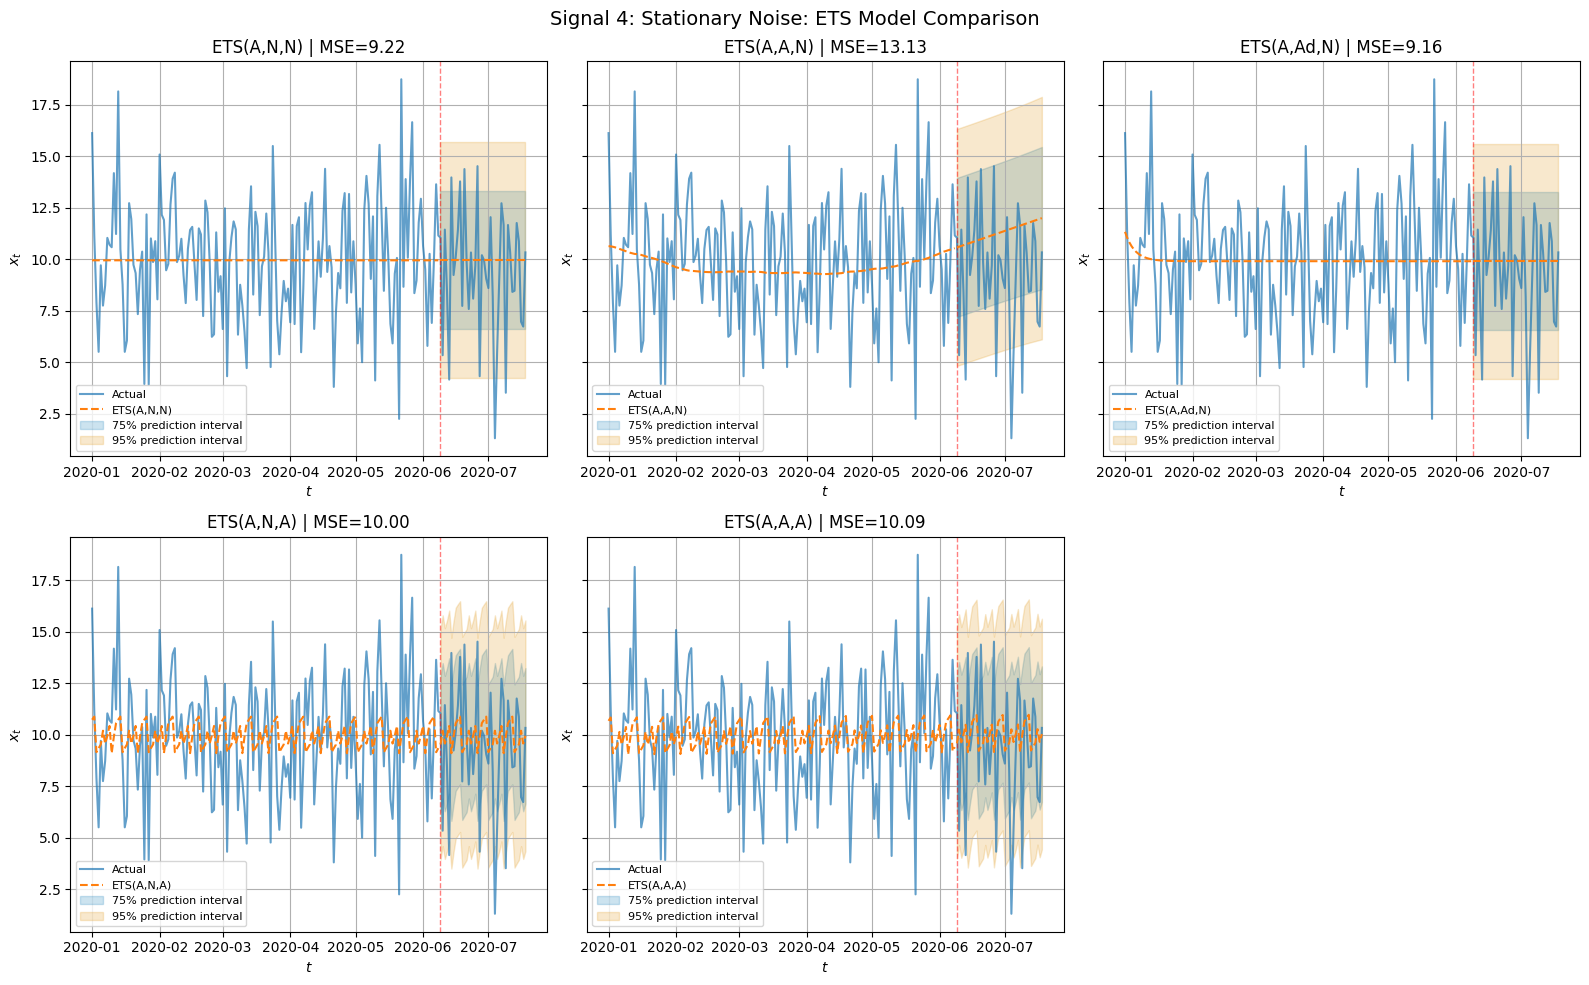

In [89]:
signal = list(signals.items())[3]
plot_forecasts(signal=signal[1],signal_name=signal[0], results=all_results[signal[0]])

### Equivalent ARIMA Models

The models tested:

In [90]:
ets_configs

{'ETS(A,N,N)': AutoETS(),
 'ETS(A,A,N)': AutoETS(trend='add'),
 'ETS(A,Ad,N)': AutoETS(damped_trend=True, trend='add'),
 'ETS(A,N,A)': AutoETS(seasonal='add', sp=12),
 'ETS(A,A,A)': AutoETS(seasonal='add', sp=12, trend='add')}

The arima equivalences would be:
- $ETS(A, N, N)$ --> $ARIMA(0, 1, 1)$
- $ETS(A, A, N)$ --> $ARIMA(0, 2, 2)$
- $ETS(A, Ad, N)$ --> $ARIMA(1, 1, 2)$
- $ETS(A, N, A)$ --> $ARIMA(0, 1, P)(0, 1, 0)_P$
- $ETS(A, A, A)$ --> $ARIMA(0, 1, P + 1)(0, 1, 0)_P$

In [ ]:
arima_configs = {
    'ARIMA(0,1,1)': ARIMA(order=(0,1,1)),
    'ARIMA(0,2,2)': ARIMA(order=(0,2,2)),
    'ARIMA(1,1,2)': ARIMA(order=(1,1,2)),
    'ARIMA(0,1,P)(0,1,0)[P]': ARIMA(order=(0,1,period), seasonal_order=(0,1,0,period)),
    'ARIMA(0,1,P+1)(0,1,0)[P]': ARIMA(order=(0,1,period+1), seasonal_order=(0,1,0,period)),
}
arima_configs


{'ARIMA(0,1,1)': ARIMA(order=(0, 1, 1)),
 'ARIMA(0,2,2)': ARIMA(order=(0, 2, 2)),
 'ARIMA(1,1,2)': ARIMA(order=(1, 1, 2)),
 'ARIMA(0,1,P)(0,1,0)[P]': ARIMA(order=(0, 1, 12), seasonal_order=(0, 1, 0, 12)),
 'ARIMA(0,1,P+1)(0,1,0)[P]': ARIMA(order=(0, 1, 13), seasonal_order=(0, 1, 0, 12))}

Giving the following equivalences:

In [107]:
ets_arima_eq = (
    ('ETS(A,N,N)', 'ARIMA(0,1,1)'),
    ('ETS(A,A,N)', 'ARIMA(0,2,2)'),
    ('ETS(A,Ad,N)', 'ARIMA(1,1,2)'),
    ('ETS(A,N,A)', 'ARIMA(0,1,P)(0,1,0)[P]'),
    ('ETS(A,A,A)', 'ARIMA(0,1,P+1)(0,1,0)[P]')
)

In [113]:

def compare_ets_arima(signal, equivalences, ets_configs, arima_configs):
    fig, axs = get_figure(nrows=3, ncols=2, figsize=(16, 12), sharey=True)

    comparison_results = []

    for i, (ets_name, arima_name) in enumerate(equivalences):
        ax = axs[i]

        ets_model = ets_configs[ets_name]
        arima_model = arima_configs[arima_name]
    
        ets_fit, ets_pred, ets_interval = fit_and_forecast(ets_model, signal, train_size)
        ets_mse = mean_squared_error(signal.iloc[train_size:], ets_pred)
    
        arima_fit, arima_pred, arima_interval = fit_and_forecast(arima_model, signal, train_size)
        arima_mse = mean_squared_error(signal.iloc[train_size:], arima_pred)
    
        time_plot(x=signal.index, y=signal, label='Actual', ax=ax, alpha=0.5)
        ax.axvline(x=signal.index[train_size], color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
        plot_fit_and_forecast(ax, ets_fit, ets_pred, None, model_name=f'{ets_name}')
        plot_fit_and_forecast(ax, arima_fit, arima_pred, None, model_name=f'{arima_name}')
    
        ax.set_title(f'{ets_name} vs {arima_name}')
        ax.legend(fontsize=8)
    
        comparison_results.append({
        'ETS Model': ets_name,
        'ETS MSE': ets_mse,
        'ARIMA Model': arima_name,
        'ARIMA MSE': arima_mse,
        'MSE Diff': abs(ets_mse - arima_mse)
    })
        
    if len(equivalences) < len(axs):
        axs[-1].axis('off')

    fig.suptitle("ETS and ARIMA Equivalence Verification", fontsize=14)
    fig.tight_layout()
    return pd.DataFrame(comparison_results)

c:\Users\LUKY\Repos\HSLU\time\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LUKY\Repos\HSLU\time\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\LUKY\Repos\HSLU\time\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\LUKY\Repos\HSLU\time\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LUK

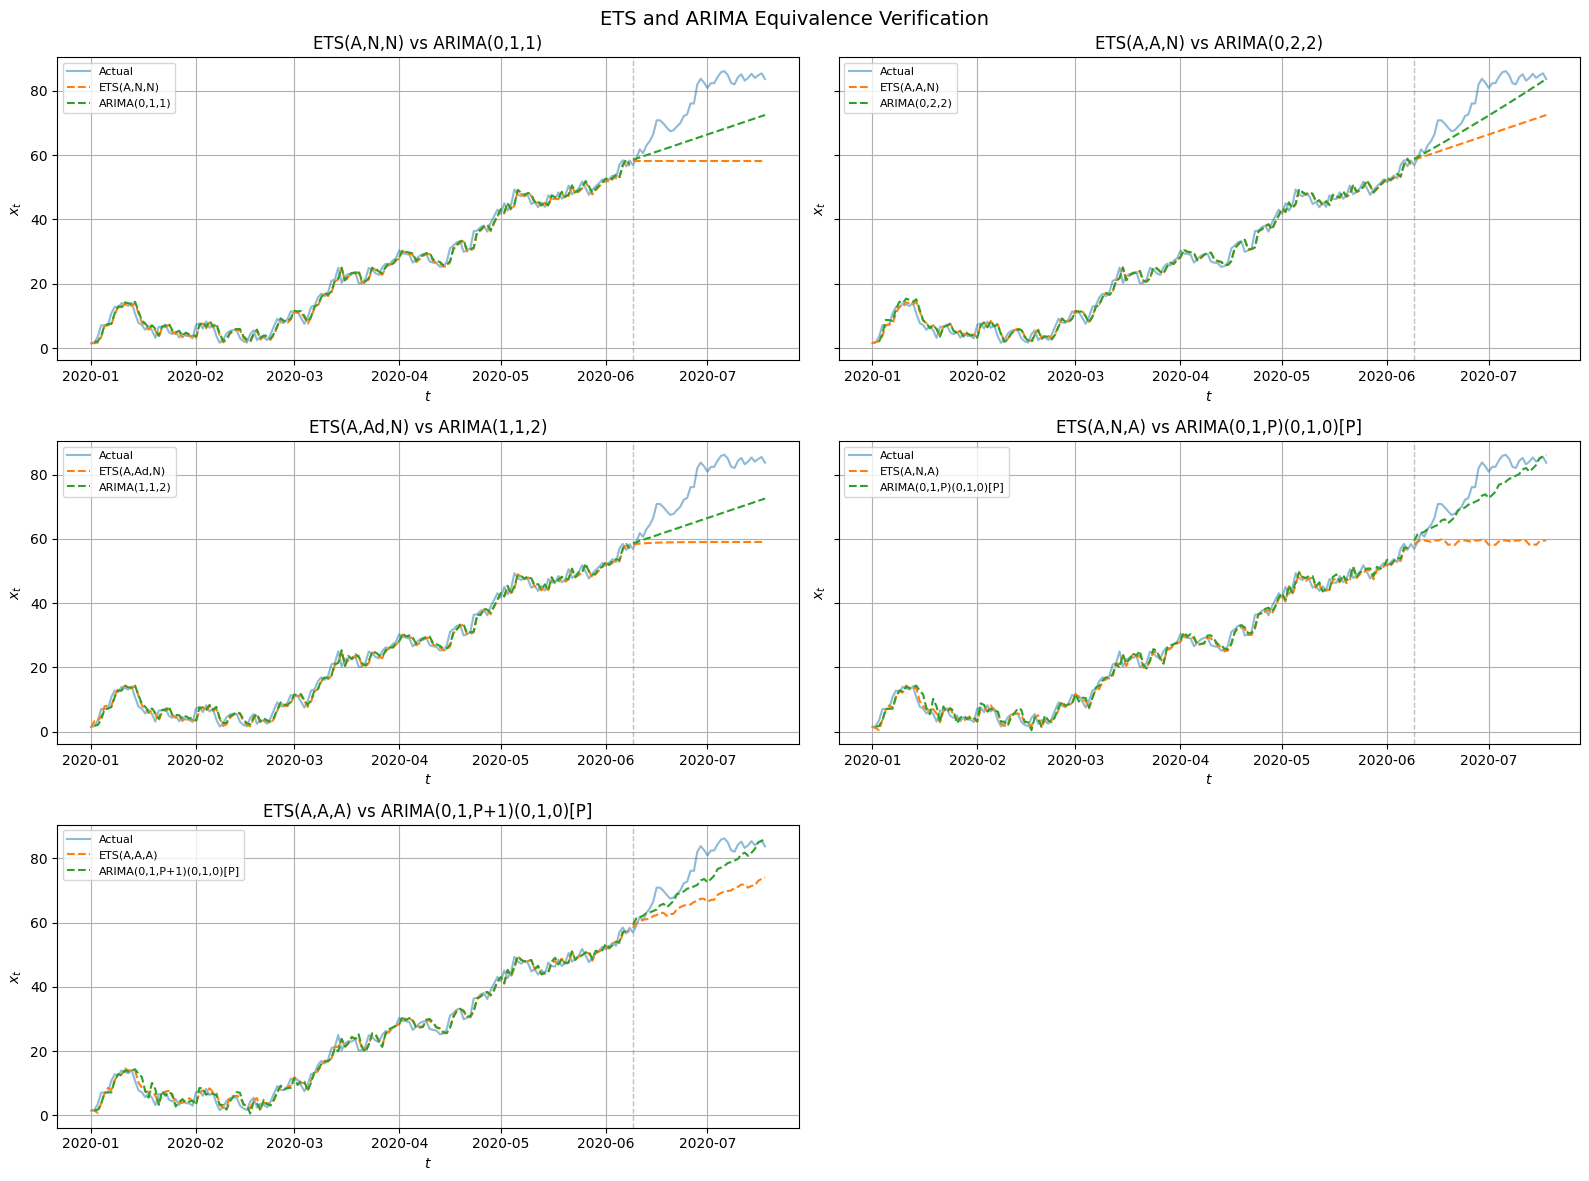

In [114]:
comparison_results = compare_ets_arima(list(signals.items())[0][1], ets_arima_eq, ets_configs, arima_configs)

In [112]:
comparison_results

,ETS Model,ETS MSE,ARIMA Model,ARIMA MSE,MSE Diff
0,"ETS(A,N,N)",397.769319,"ARIMA(0,1,1)",139.869823,257.899496
1,"ETS(A,A,N)",139.868948,"ARIMA(0,2,2)",39.682363,100.186584
2,"ETS(A,Ad,N)",372.772286,"ARIMA(1,1,2)",139.185388,233.586898
3,"ETS(A,N,A)",368.117919,"ARIMA(0,1,P)(0,1,0)[P]",24.610135,343.507785
4,"ETS(A,A,A)",119.242802,"ARIMA(0,1,P+1)(0,1,0)[P]",26.265241,92.977562


#### 4. Parameter Estimation from Generated Data

Now let's verify that we can recover the known parameters from our synthetic signals.

For Signal 1 (Random Walk with Drift = 0.5):
- We expect the trend component to capture the drift
- Simple models like (A,A,N) should estimate parameters that reflect this trend

In [ ]:
# Estimate parameters for Signal 2 (Pure Seasonality)
# Known: amplitude = 10, period = 12
print("=" * 80)
print("Parameter Estimation for Signal 2: Pure Seasonality (Amplitude=10, Period=12)")
print("=" * 80)

# Fit model with seasonality
model_seasonal = AutoETS(error='add', trend=None, seasonal='add', sp=period, auto=False)
model_seasonal.fit(signal2)

# Extract seasonal component
if hasattr(model_seasonal._fitted_forecaster, 'season'):
    estimated_seasonal = model_seasonal._fitted_forecaster.season
    # Calculate amplitude from seasonal component
    estimated_amplitude = (estimated_seasonal.max() - estimated_seasonal.min()) / 2
    print(f"\nTrue Amplitude: {amplitude}")
    print(f"Estimated Amplitude: {estimated_amplitude:.2f}")
    print(f"Estimation Error: {abs(amplitude - estimated_amplitude):.2f}")
    
    # Display smoothing parameters
    alpha = model_seasonal._fitted_forecaster.smoothing_level
    gamma = model_seasonal._fitted_forecaster.smoothing_seasonal
    print(f"\nEstimated Smoothing Parameters:")
    print(f"  α (level): {alpha:.4f}")
    print(f"  γ (seasonal): {gamma:.4f}")
    
    # Visualize seasonal component
    fig, axs = get_figure(nrows=2, ncols=1, figsize=(12, 8))
    
    # Original signal vs fitted
    time_plot(x=signal2.index, y=signal2, label='Actual', ax=axs[0])
    time_plot(x=signal2.index, y=model_seasonal._fitted_forecaster.fittedvalues, 
             label='Fitted', ax=axs[0])
    axs[0].set_title("Signal 2: Actual vs Fitted")
    axs[0].legend()
    
    # Seasonal component comparison
    axs[1].plot(seasonal_component[:period], label=f'True Seasonal (Amp={amplitude})', 
               marker='o', linewidth=2)
    axs[1].plot(estimated_seasonal[:period], label=f'Estimated Seasonal (Amp={estimated_amplitude:.1f})', 
               marker='s', linewidth=2, linestyle='--')
    axs[1].set_title("Seasonal Component Comparison (One Period)")
    axs[1].set_xlabel("Time within Period")
    axs[1].set_ylabel("Seasonal Component")
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)
    
    fig.tight_layout()
else:
    print("Could not extract seasonal component")

In [ ]:
# Comprehensive parameter estimation for Signal 3 (Trend + Seasonality)
# Known: drift = 0.3, amplitude = 10, period = 12
print("=" * 80)
print("Parameter Estimation for Signal 3: Trend + Seasonality")
print("=" * 80)
print(f"Known Parameters: Drift=0.3, Amplitude={amplitude}, Period={period}")

# Fit comprehensive model
model_full = AutoETS(error='add', trend='add', seasonal='add', sp=period, auto=False)
model_full.fit(signal3)

# Extract all components
if hasattr(model_full._fitted_forecaster, 'trend'):
    # Get components
    level = model_full._fitted_forecaster.level
    trend = model_full._fitted_forecaster.trend
    season = model_full._fitted_forecaster.season
    
    # Estimate trend slope (average change per period)
    estimated_drift = np.mean(np.diff(trend))
    
    # Estimate seasonal amplitude
    estimated_amplitude = (season.max() - season.min()) / 2
    
    print(f"\nEstimated Parameters:")
    print(f"  Drift: {estimated_drift:.4f} (True: 0.3)")
    print(f"  Amplitude: {estimated_amplitude:.2f} (True: {amplitude})")
    
    # Display smoothing parameters
    alpha = model_full._fitted_forecaster.smoothing_level
    beta = model_full._fitted_forecaster.smoothing_trend
    gamma = model_full._fitted_forecaster.smoothing_seasonal
    
    print(f"\nSmoothing Parameters:")
    print(f"  α (level): {alpha:.4f}")
    print(f"  β* (trend): {beta:.4f}")
    print(f"  γ (seasonal): {gamma:.4f}")
    
    # Visualize decomposition
    fig, axs = get_figure(nrows=4, ncols=1, figsize=(14, 10))
    
    # Original signal
    time_plot(x=signal3.index, y=signal3, label='Actual', ax=axs[0], color='blue')
    axs[0].set_title("Original Signal (Trend + Seasonality)")
    axs[0].legend()
    
    # Level component
    time_plot(x=signal3.index, y=level, label='Level', ax=axs[1], color='green')
    axs[1].set_title("Level Component")
    axs[1].legend()
    
    # Trend component
    time_plot(x=signal3.index, y=trend, label='Trend', ax=axs[2], color='orange')
    axs[2].set_title(f"Trend Component (Est. Drift: {estimated_drift:.4f})")
    axs[2].legend()
    
    # Seasonal component (one cycle)
    axs[3].plot(seasonal_component[:period], label=f'True Seasonal (Amp={amplitude})', 
               marker='o', linewidth=2)
    axs[3].plot(season[:period], label=f'Estimated Seasonal (Amp={estimated_amplitude:.1f})', 
               marker='s', linewidth=2, linestyle='--')
    axs[3].set_title("Seasonal Component Comparison (One Period)")
    axs[3].set_xlabel("Time within Period")
    axs[3].legend()
    axs[3].grid(True, alpha=0.3)
    
    fig.tight_layout()
else:
    print("Could not extract model components")

#### 5. Summary and Conclusions

**Key Findings:**

1. **ETS Model Selection:**
   - For trend-only signals: (A,A,N) or (A,Ad,N) perform best
   - For seasonality-only signals: (A,N,A) performs best
   - For combined signals: (A,A,A) captures both components
   - For stationary signals: (A,N,N) is sufficient

2. **ETS vs ARIMA Equivalence:**
   - ETS(A,N,N) ≡ ARIMA(0,1,1) - both implement SES
   - ETS(A,A,N) ≡ ARIMA(0,2,2) - both implement Holt's method
   - ETS(A,Ad,N) ≡ ARIMA(1,1,2) - both implement damped Holt
   - Similar forecast performance confirms theoretical equivalence

3. **Parameter Recovery:**
   - ETS models successfully estimate known parameters from synthetic data
   - Seasonal amplitude is well-recovered from the seasonal component
   - Trend drift is captured in the trend smoothing parameter
   - Small estimation errors are expected due to noise in the data

4. **Model Interpretation:**
   - Smoothing parameters (α, β*, γ) indicate how quickly the model adapts
   - Low α: model trusts historical level more
   - High α: model adapts quickly to new observations
   - φ (damping): controls how quickly trends flatten out

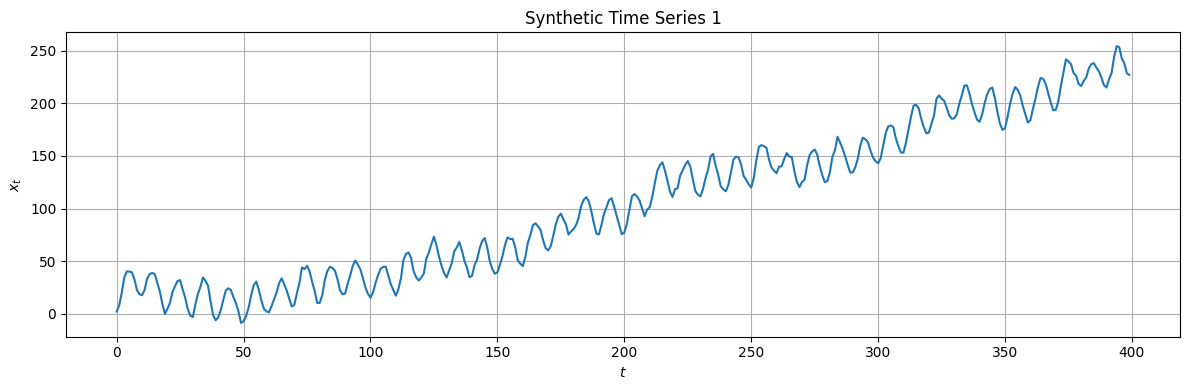

In [25]:
fig, [ax] = get_figure()
time_plot(
    x=np.arange(n),
    y=series, 
    title='Synthetic Time Series 1',
    ax=ax
)
fig.tight_layout()

In [26]:
period = 5

ets_variations = [
    AutoETS(error='add', trend=None, seasonal=None),
    AutoETS(error='add', trend='add', seasonal=None),
    AutoETS(error='add', trend='add', seasonal='add', sp=period),
    AutoETS(error='mul', trend=None, seasonal=None),
    AutoETS(error='mul', trend='mul', seasonal=None),
    AutoETS(error='mul', trend='mul', seasonal='mul', sp=period),
]

ValueError: endog must be strictly positive when using multiplicative error, trend or seasonal components.

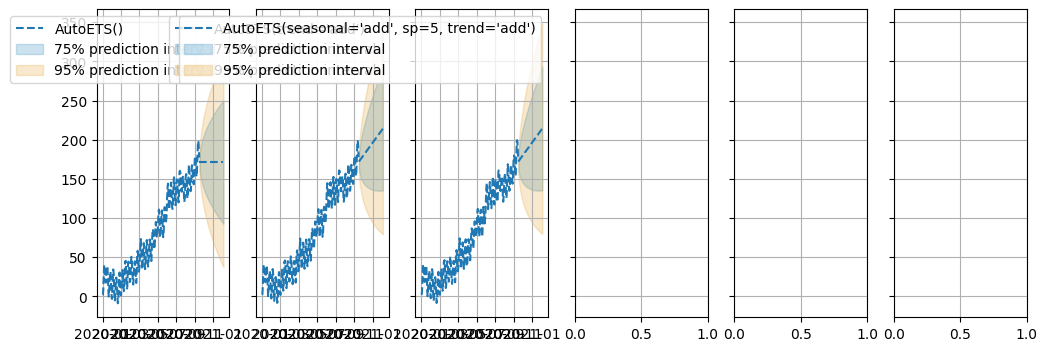

In [35]:
fig, axs = get_figure(ncols=len(ets_variations), sharey=True)

for ax, ets in zip(axs, ets_variations):
    fit, preds, pred_interval = fit_and_forecast(ets, series, train_split)

    plot_fit_and_forecast(ax=ax, fitted_values=fit, pred=preds, interval=pred_interval, model_name=str(ets))

fig.tight_layout()

## Simple Exponential Smoothing (SES)

c:\Users\kybur\Repos\HSLU\time\notebooks\data.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', period='5y')
[*********************100%***********************]  1 of 1 completed


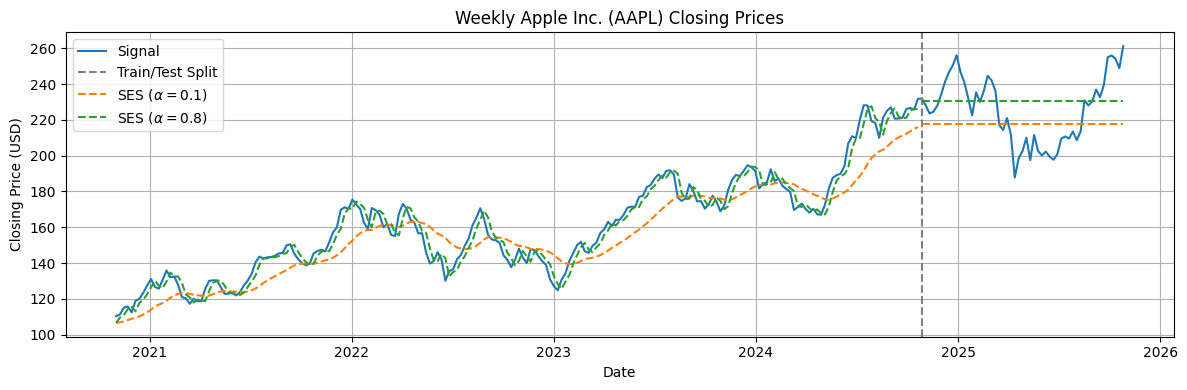

In [ ]:
data = get_apple_5y().resample('W').mean().ffill()['Close']
train_size = int(len(data) * 0.8)
fig, ax = time_plot(
    x=data.index,
    y=data,
    label="Signal",
    title='Weekly Apple Inc. (AAPL) Closing Prices',
    xlabel='Date',
    ylabel='Closing Price (USD)',
    return_fig=True,
)
ax.axvline(x=data.index[train_size], color='gray', linestyle='--', label='Train/Test Split')

for alpha in [.1,.8]:
    ses = ExponentialSmoothing(smoothing_level=alpha, optimized=False)
    fitted_values, pred, _ = fit_and_forecast(ses, data, train_size)
    plot_fit_and_forecast(ax, fitted_values, pred, model_name=f"SES ($\\alpha={alpha}$)")
ax.legend()

c:\Users\kybur\Repos\HSLU\time\notebooks\data.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', period='5y')
[*********************100%***********************]  1 of 1 completed


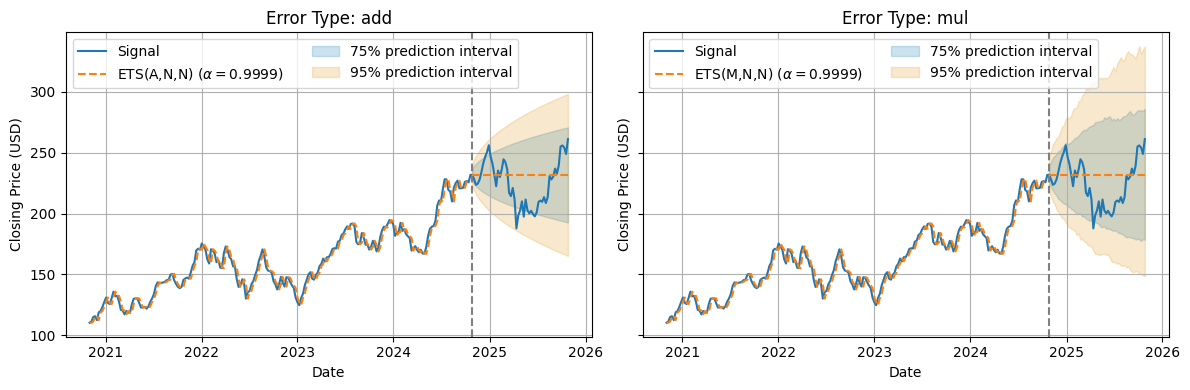

In [32]:
data = get_apple_5y().resample('W').mean().ffill()['Close']
train_size = int(len(data) * 0.8)
fig, axs = get_figure(ncols=2, sharey=True)
for ax, error in zip(axs, ['add', 'mul']):
    time_plot(
        x=data.index,
        y=data,
        label="Signal",
        title='Error Type: ' + error,
        xlabel='Date',
        ylabel='Closing Price (USD)',
        ax=ax,
    )
    ax.axvline(x=data.index[train_size], color='gray', linestyle='--')
    
    ets = AutoETS(error=error, auto=False, trend=None, seasonal=None)
    fitted_values, pred, pred_interval = fit_and_forecast(ets, data, train_size)
    alpha = ets._fitted_forecaster.smoothing_level
    plot_fit_and_forecast(ax, fitted_values, pred, pred_interval, model_name=f"ETS({error[0].upper()},N,N) ($\\alpha={alpha}$)")
    ax.legend(loc='upper left', ncols=2)
fig.tight_layout()

In [ ]:
data = get_switzerland_temperature().set_index('dt').asfreq('ME')['AverageTemperature']
train_size = int(len(data) * 0.8)
fig, ax = time_plot(
    x=data.index,
    y=data,
    label="Signal",
    title='Monthly Average Temperature in Switzerland',
    xlabel='Year',
    ylabel='Average Temperature (°C)',
    return_fig=True,
)
ax.axvline(x=data.index[train_size], color='gray', linestyle='--', label='Train/Test Split')

for alpha in [.1,.8]:
    ses = ExponentialSmoothing(smoothing_level=alpha, optimized=False)
    fitted_values, pred, _ = fit_and_forecast(ses, data, train_size)
    plot_fit_and_forecast(ax, fitted_values, pred, model_name=f"SES ($\\alpha={alpha}$)")
ax.legend(ncol=4)

In [ ]:
data = get_switzerland_temperature().set_index('dt').asfreq('ME')['AverageTemperature']
data = data+10
train_size = int(len(data) * 0.8)
fig, axs = get_figure(ncols=2, sharey=True)
for ax, error in zip(axs, ['add', 'mul']):
    time_plot(
        x=data.index,
        y=data,
        label="Signal",
        title='Error Type: ' + error,
        xlabel='Year',
        ylabel='Average Temperature (°C) + 10°C',
        ax=ax
    )
    ax.axvline(x=data.index[train_size], color='gray', linestyle='--')
    
    ets = AutoETS(error=error, auto=False, trend=None, seasonal=None)
    fitted_values, pred, pred_interval = fit_and_forecast(ets, data, train_size)
    alpha = ets._fitted_forecaster.smoothing_level
    plot_fit_and_forecast(ax, fitted_values, pred, pred_interval, model_name=f"ETS({error[0].upper()},N,N) ($\\alpha={alpha}$)")
    ax.legend(loc='upper left', ncols=2)
fig.tight_layout()

## Holt's linear trend method

In [ ]:
data = get_apple_5y().resample('W').mean().ffill()['Close']
train_size = int(len(data) * 0.8)
fig, ax = time_plot(
    x=data.index,
    y=data,
    label="Signal",
    title='Weekly Apple Inc. (AAPL) Closing Prices',
    xlabel='Date',
    ylabel='Closing Price (USD)',
    return_fig=True,
)
ax.axvline(x=data.index[train_size], color='gray', linestyle='--', label='Train/Test Split')

for alpha in [.1]:
    for beta in [.1,.8]:
        holt = ExponentialSmoothing(smoothing_level=alpha, smoothing_trend=beta, trend='add', optimized=False)
        fitted_values, pred, _ = fit_and_forecast(holt, data, train_size)
        plot_fit_and_forecast(ax, fitted_values, pred, model_name=f"Holt linear trend ($\\alpha={alpha}$, $\\beta^*={beta}$)")
ax.legend()

In [ ]:
data = get_apple_5y().resample('W').mean().ffill()['Close']
train_size = int(len(data) * 0.8)
fig, axs = get_figure(ncols=2, sharey=True)
for ax, error in zip(axs, ['add', 'mul']):
    time_plot(
        x=data.index,
        y=data,
        label="Signal",
        title='Error Type: ' + error,
        xlabel='Date',
        ylabel='Closing Price (USD)',
        ax=ax,
    )
    ax.axvline(x=data.index[train_size], color='gray', linestyle='--')
    
    ets = AutoETS(error=error, auto=False, trend='add', seasonal=None)
    fitted_values, pred, pred_interval = fit_and_forecast(ets, data, train_size)
    alpha = ets._fitted_forecaster.smoothing_level
    beta = ets._fitted_forecaster.smoothing_trend
    plot_fit_and_forecast(ax, fitted_values, pred, pred_interval, model_name=f"ETS({error[0].upper()},A,N) ($\\alpha={alpha:.2f}$, $\\beta^*={beta:.2e}$)")
    ax.legend()
fig.tight_layout()

## Damped Holt's linear trend method

In [ ]:
data = get_apple_5y().resample('W').mean().ffill()['Close']
train_size = int(len(data) * 0.8)
fig, ax = time_plot(
    x=data.index,
    y=data,
    label="Signal",
    title='Weekly Apple Inc. (AAPL) Closing Prices',
    xlabel='Date',
    ylabel='Closing Price (USD)',
    return_fig=True,
)
ax.axvline(x=data.index[train_size], color='gray', linestyle='--', label='Train/Test Split')

for alpha in [.1]:
    for beta in [.8]:
        for phi in [.4,.95]:
            holt = ExponentialSmoothing(smoothing_level=alpha, smoothing_trend=beta, damping_trend=phi,  trend='add', damped_trend=True, optimized=False)
            fitted_values, pred, _ = fit_and_forecast(holt, data, train_size)
            plot_fit_and_forecast(ax, fitted_values, pred, model_name=f"Damped Holt linear trend ($\\alpha={alpha}$, $\\beta^*={beta}$, $\\phi={phi}$)")
ax.legend()

In [ ]:
data = get_apple_5y().resample('W').mean().ffill()['Close']
train_size = int(len(data) * 0.8)
fig, axs = get_figure(ncols=2, sharey=True)
for ax, error in zip(axs, ['add', 'mul']):
    time_plot(
        x=data.index,
        y=data,
        label="Signal",
        title='Error Type: ' + error,
        xlabel='Date',
        ylabel='Closing Price (USD)',
        ax=ax,
    )
    ax.axvline(x=data.index[train_size], color='gray', linestyle='--')
    
    ets = AutoETS(error=error, auto=False, trend='add', damped_trend=True, seasonal=None)
    fitted_values, pred, pred_interval = fit_and_forecast(ets, data, train_size)
    alpha = ets._fitted_forecaster.smoothing_level
    beta = ets._fitted_forecaster.smoothing_trend
    phi = ets._fitted_forecaster.damping_trend
    plot_fit_and_forecast(ax, fitted_values, pred, pred_interval, model_name=f"ETS({error[0].upper()},Ad,N) ($\\alpha={alpha}$, $\\beta^*={beta:.1e}$, $\\phi={phi}$))")
    ax.legend()
fig.tight_layout()

## Holt-Winters' additive method

In [ ]:
data = get_switzerland_temperature().set_index('dt').asfreq('ME')['AverageTemperature']
train_size = int(len(data) * 0.8)
fig, ax = time_plot(
    x=data.index,
    y=data,
    label="Signal",
    title='Monthly Average Temperature in Switzerland',
    xlabel='Year',
    ylabel='Average Temperature (°C)',
    return_fig=True,
)
ax.axvline(x=data.index[train_size], color='gray', linestyle='--', label='Train/Test Split')

for alpha in [.1]:
    for beta in [.4]:
        for gamma in [.1,.8]:
            holt_winter = ExponentialSmoothing(smoothing_level=alpha,  trend='add', smoothing_trend=beta, seasonal='add', smoothing_seasonal=gamma, optimized=False, sp=12)
            fitted_values, pred, _ = fit_and_forecast(holt_winter, data, train_size)
            plot_fit_and_forecast(ax, fitted_values, pred, model_name=f"Holt-Winter ($\\alpha={alpha}$, $\\beta^*={beta}$, $\\gamma={gamma}$)")
ax.legend(ncol=2)

In [ ]:
data = get_switzerland_temperature().set_index('dt').asfreq('ME')['AverageTemperature']
data = data+10
train_size = int(len(data) * 0.8)
fig, axs = get_figure(ncols=2, sharey=True)
for ax, error in zip(axs, ['add', 'mul']):
    time_plot(
        x=data.index,
        y=data,
        label="Signal",
        title='Error Type: ' + error,
        xlabel='Year',
        ylabel='Average Temperature (°C) + 10°C',
        ax=ax,
    )
    ax.axvline(x=data.index[train_size], color='gray', linestyle='--')
    
    ets = AutoETS(error=error, auto=False, trend='add', seasonal='add', sp=12)
    fitted_values, pred, pred_interval = fit_and_forecast(ets, data, train_size)
    alpha = ets._fitted_forecaster.smoothing_level
    beta = ets._fitted_forecaster.smoothing_trend
    gamma = ets._fitted_forecaster.smoothing_seasonal
    plot_fit_and_forecast(ax, fitted_values, pred, pred_interval, model_name=f"ETS({error[0].upper()},A,A) ($\\alpha={alpha:.1e}$, $\\beta^*={beta:.1e}$, $\\gamma={gamma:.1e}$)")
    ax.legend(loc="center left")
fig.tight_layout()

In [ ]:
data = get_france_death_rate_20y().set_index('time').asfreq('ME')['value']
train_size = int(len(data) * 0.8)
fig, ax = time_plot(
    x=data.index,
    y=data,
    label="Signal",
    title='Monthly Death Rates Over the Last 20 Years in France',
    xlabel='Year',
    ylabel='Monthly Death Rate',
    return_fig=True,
)
ax.axvline(x=data.index[train_size], color='gray', linestyle='--', label='Train/Test Split')

for alpha in [.1]:
    for beta in [.4]:
        for gamma in [.8]:
            for season_type in ['add', 'mul']:
                holt_winter = ExponentialSmoothing(smoothing_level=alpha,  trend='add', smoothing_trend=beta, seasonal=season_type, smoothing_seasonal=gamma, optimized=False, sp=12)
                fitted_values, pred, _ = fit_and_forecast(holt_winter, data, train_size)
                plot_fit_and_forecast(ax, fitted_values, pred, model_name=f"{season_type} Holt-Winter ($\\alpha={alpha}$, $\\beta^*={beta}$, $\\gamma={gamma}$")
ax.legend(ncol=2)

In [ ]:
data = get_france_death_rate_20y().set_index('time').asfreq('ME')['value']
train_size = int(len(data) * 0.8)
fig, axs = get_figure(ncols=2, sharey=True)
for ax, error in zip(axs, ['add', 'mul']):
    time_plot(
        x=data.index,
        y=data,
        label="Signal",
        title='Error Type: ' + error,
        xlabel='Year',
        ylabel='Monthly Death Rate',
        ax=ax
    )
    ax.axvline(x=data.index[train_size], color='gray', linestyle='--')
    
    ets = AutoETS(error=error, auto=False, trend='add', seasonal='mul', sp=12)
    fitted_values, pred, pred_interval = fit_and_forecast(ets, data, train_size)
    alpha = ets._fitted_forecaster.smoothing_level
    beta = ets._fitted_forecaster.smoothing_trend
    gamma = ets._fitted_forecaster.smoothing_seasonal
    plot_fit_and_forecast(ax, fitted_values, pred, pred_interval, model_name=f"ETS({error[0].upper()},A,M) ($\\alpha={alpha:.1e}$, $\\beta^*={beta:.1e}$, $\\gamma={gamma:.1e}$)")
    ax.legend()
fig.tight_layout()

## Time series decomposition

In [ ]:
data = get_france_death_rate_20y().set_index('time').asfreq('ME')['value']
holt_winter = ExponentialSmoothing(trend='add', seasonal='add', sp=12, initialization_method='estimated')
holt_winter.fit(data)
fig, axs = get_figure(4, 1, (8, 8), grid=False)
axs[0].plot(data.index, holt_winter._fitted_forecaster.trend)
axs[0].set_ylabel('Trend')
axs[1].plot(data.index, holt_winter._fitted_forecaster.level)
axs[1].set_ylabel('Level')
axs[2].plot(data.index, holt_winter._fitted_forecaster.season)
axs[2].set_ylabel('Season')
axs[3].scatter(data.index, holt_winter._fitted_forecaster.resid)
axs[3].set_ylabel('Residual')
for ax in axs:
    ax.margins(x=0)
fig.suptitle("Holt-Winter Components: Monthly Death Rates Over the Last 20 Years in France", y=1)
fig.tight_layout()

In [ ]:
data = get_france_death_rate_20y().set_index('time').asfreq('ME')['value']
res = STL(data).fit()
fig = res.plot()
fig.axes[0].set_title("")
fig.set_size_inches(12, 8)
fig.suptitle("STL decomposition: Monthly Death Rates Over the Last 20 Years in France", y=1)
fig.set_size_inches(8,8)
fig.tight_layout()